# **Secnd PML Project**
Ghadamiyan Lida, class 407 AI

### Libraries

In [120]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('wordnet')
nltk.download('punkt')
stemmer = SnowballStemmer('russian')

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans, DBSCAN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import fowlkes_mallows_score

import seaborn as sns

from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer

from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Preprocessing

In [40]:
data = pd.read_csv('labeled.csv')

In [55]:
# Plotting the distribution of the labels
toxicc = 0
okc = 0
for label in data['toxic']:
    if label == 1:
        toxicc += 1
    if label == 0:
        okc += 1

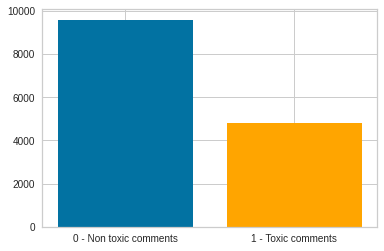

In [62]:
plt.bar('0 - Non toxic comments', okc)
plt.bar('1 - Toxic comments', toxicc, color = 'orange')
plt.show()

In [41]:
data2 = []
for i in range(0, len(data.index)):

    # Punctuation removal
    table = str.maketrans(dict.fromkeys(string.punctuation))                   
    sentences = (data.comment[i].translate(table))

    # " '\n " removal
    words = sentences[:-3] 

    # Tokenization
    words = nltk.word_tokenize(words)

    # shrt words removal & lemmatization & stemming
    words_ = []
    for word in words:
        if len(word) > 2:   
            if not word.isnumeric():                                                  
                word1 = stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v'))          
                words_.append(word1)
    data2.append(words_)

df = pd.DataFrame({'comment':data2, 'toxic':data['toxic']})   

In [4]:
comparison = pd.DataFrame({'comments': data['comment'], 'preprocessed comments': data2, 'labels': data['toxic']})
comparison.head()

,comments,preprocessed comments
0,"Верблюдов-то за что? Дебилы, бл...\n","[верблюдовт, что, дебил]"
1,"Хохлы, это отдушина затюканого россиянина, мол...","[хохл, эт, отдушин, затюкан, россиянин, мол, в..."
2,Собаке - собачья смерть\n,"[собак, собач, смер]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...","[страниц, обнов, деб, эт, тож, оскорблен, дока..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...","[теб, убед, 6страничн, пдф, том, что, скрипал,..."


In [5]:
train_data__, test_data__, train_labels, test_labels = train_test_split(df['comment'], df['toxic'], test_size = 0.2, random_state = 25)

In [6]:
# CountVectorizer & TermFrequencies
cvect = CountVectorizer(ngram_range=(1, 1), lowercase='true')   
tfidf_transformer = TfidfTransformer(norm= 'l2', use_idf= False)

In [7]:
# Transforming the processed data to a list (for tfidf)
data4 = train_data__.astype(str).values.tolist()

train_data1 = cvect.fit_transform(data4)
train_data = tfidf_transformer.fit_transform(train_data1)

In [8]:
# Same procedure for the test data
data5 = test_data__.astype(str).values.tolist()

test_data1 = cvect.transform(data5)
test_data = tfidf_transformer.transform(test_data1)

In [9]:
# Same procedure for the entire data set
train_data6 = df['comment'].astype(str).values.tolist()

data1_ = cvect.fit_transform(train_data6)
data_ = tfidf_transformer.fit_transform(data1_)

### Data visualization

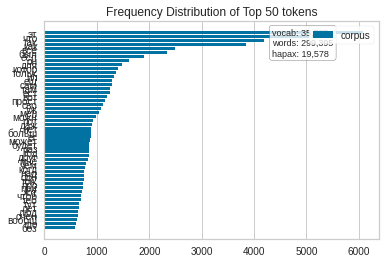

In [10]:
#https://www.scikit-yb.org/en/latest/api/text/freqdist.html
features = cvect.get_feature_names()

visualizer = FreqDistVisualizer(features=features)
visualizer.fit(data1_)
visualizer.poof()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


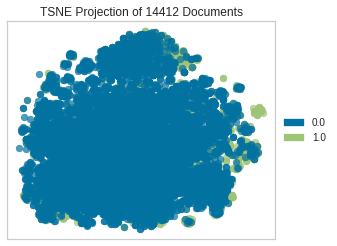

In [11]:
#https://www.scikit-yb.org/en/latest/api/text/freqdist.html

tsne = TSNEVisualizer()
tsne.fit_transform(data_, df['toxic'])
tsne.poof()

## Supervised learning method - Naive Bayes

In [12]:
# Model fitting
model = MultinomialNB(alpha = 0.1)
model.fit(train_data, train_labels)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [13]:
# Prediction
prediction = model.predict(test_data)

We are using two scores to compare the results

Accuracy score = $\frac{TP + TN}{Total}$

Fowlkes Mallwows Score = $\frac{TP}{\sqrt(TP+FP)(TP+FN}$ 

In [14]:
accuracy_score(test_labels, prediction) 

0.8515435310440513

In [15]:
print(fowlkes_mallows_score(prediction, test_labels))

0.790984099645179


In [16]:
models = Pipeline([('CountVect', CountVectorizer()), 
                     ('TermFreq', TfidfTransformer()), 
                     ('NB', MultinomialNB())]) 

parameters = { 'CountVect__ngram_range': [(1, 1), (1, 2), (2, 2),(4,5)], 
              'TermFreq__use_idf': (True, False), 
              'TermFreq__norm': ('l1', 'l2'), 
              'NB__alpha': [1, 1e-1, 1e-2, 1e-3] } 

CrossValFolds = 5
grid_search= GridSearchCV(models, parameters, cv = CrossValFolds, n_jobs = -1) 
grid_search.fit(data4, train_labels)

print(grid_search.best_score_) 
print(grid_search.best_params_)

0.8637348198512604
{'CountVect__ngram_range': (1, 1), 'NB__alpha': 0.1, 'TermFreq__norm': 'l2', 'TermFreq__use_idf': True}


In [17]:
print(classification_report(test_labels, prediction))

              precision    recall  f1-score   support

         0.0       0.84      0.96      0.90      1935
         1.0       0.88      0.63      0.74       948

    accuracy                           0.85      2883
   macro avg       0.86      0.80      0.82      2883
weighted avg       0.86      0.85      0.84      2883



In [127]:
confusion_matrix(test_labels, prediction, )

array([[1857,   78],
       [ 350,  598]])

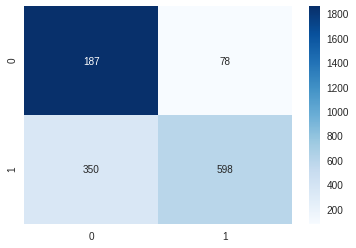

In [142]:
ax = sns.heatmap(confusion_matrix(test_labels, prediction), annot = np.array([['187', '78'],['350', '598']]), cmap=plt.cm.Blues, fmt = '')

# Unsupervised methods

## K-means

In [18]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0).fit(data_)

In [19]:
kmeans_pred = []
for label in kmeans.predict(data_):
    if label == 0:
        kmeans_pred.append(1)
    else:
        kmeans_pred.append(0)

In [20]:
fowlkes_mallows_score(kmeans_pred, df['toxic']) 

0.5767237534746894

In [21]:
def accuracy_score_(labels__, labels___):
    score = 0
    for idx, label in enumerate(labels__):
        if label == labels___[idx]:
            score = score + 1

    return score/len(labels___)

In [22]:
accuracy_score_(kmeans_pred, df['toxic'])

0.5530807660283097

In [23]:
print(classification_report(df['toxic'], kmeans_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.72      0.68      9586
         1.0       0.29      0.23      0.25      4826

    accuracy                           0.55     14412
   macro avg       0.47      0.47      0.47     14412
weighted avg       0.53      0.55      0.54     14412



In [123]:
confusion_matrix(df['toxic'], kmeans_pred)

array([[6878, 2708],
       [3733, 1093]])

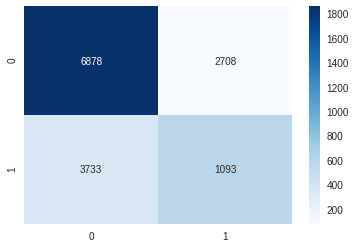

In [143]:
ax = sns.heatmap(confusion_matrix(test_labels, prediction), annot = np.array([['6878', '2708'],['3733', '1093']]), cmap=plt.cm.Blues, fmt = '')

### Elbow method

In [89]:
Y = []
for k in range(1,10):
    kmean_ = KMeans(n_clusters=k).fit(data_)
    Y.append(kmean_.inertia_)

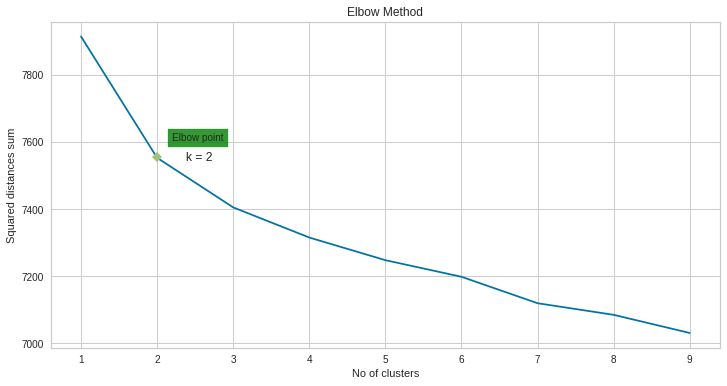

In [110]:
X = range(1,10)

plt.figure(figsize=(12,6))
plt.plot(X, Y)
plt.plot(2, 7554, 'gD')

plt.text(2.2, 7603, 'Elbow point', bbox=dict(color='green', alpha=0.8))
plt.text(2.38, 7545, 'k = 2', fontsize = 12)

plt.ylabel('Squared distances sum')
plt.xlabel('No of clusters')
plt.title('Elbow Method')

plt.show()

## DBSCAN

In [73]:
# Dimensionality reduction
SVD = TruncatedSVD(100)
Pca = SVD.fit_transform(data_)

# Makeing the data positive
scaler = MinMaxScaler().fit(Pca)
data_ = scaler.transform(Pca)

In [70]:
clustering = DBSCAN(eps=0.9, min_samples=2).fit(data_)

In [71]:
fowlkes_mallows_score(clustering.labels_, data['toxic'])

0.7393796218644814

In [72]:
accuracy_score_(clustering.labels_, data['toxic'])

0.6602830974188176

###Parameter Tunning

In [75]:
# Computing a tabel for parameter comparison

Acc = []
Param = []
X_ = []
print('Clusters \t Acc \t eps \t min_samples')
for eps_ in [ 0.6, 0.8, 0.9]:
    for min_samples_ in range(1, 10):
        clustering = DBSCAN(eps=eps_, min_samples=min_samples_).fit(data_)
        n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
        print( n_clusters,' \t       ', round(accuracy_score_(clustering.labels_, data['toxic']), 3),'\t ', eps_, '  \t ', min_samples_)
        
        X_.append(accuracy_score_(clustering.labels_, data['toxic']))
        if n_clusters == 2 or n_clusters == 3:
            Acc.append(accuracy_score_(clustering.labels_, data['toxic']))
            Param.append([eps_, min_samples_])

Clusters 	 Acc 	 eps 	 min_samples
4746  	        0.406 	  0.6   	  1
127  	        0.406 	  0.6   	  2
6  	        0.406 	  0.6   	  3
1  	        0.405 	  0.6   	  4
1  	        0.403 	  0.6   	  5
1  	        0.402 	  0.6   	  6
1  	        0.401 	  0.6   	  7
1  	        0.4 	  0.6   	  8
1  	        0.399 	  0.6   	  9
543  	        0.635 	  0.8   	  1
14  	        0.635 	  0.8   	  2
1  	        0.635 	  0.8   	  3
1  	        0.634 	  0.8   	  4
1  	        0.634 	  0.8   	  5
1  	        0.634 	  0.8   	  6
1  	        0.634 	  0.8   	  7
1  	        0.634 	  0.8   	  8
1  	        0.634 	  0.8   	  9
91  	        0.66 	  0.9   	  1
3  	        0.66 	  0.9   	  2
1  	        0.66 	  0.9   	  3
1  	        0.66 	  0.9   	  4
1  	        0.66 	  0.9   	  5
1  	        0.66 	  0.9   	  6
1  	        0.66 	  0.9   	  7
1  	        0.66 	  0.9   	  8
1  	        0.66 	  0.9   	  9


In [76]:
print('Best score: ', max(Acc),'\nBest Parameters: eps_ = ', Param[np.argmax(Acc, axis = 0)][0], ', min_sample = ', Param[np.argmax(Acc, axis = 0)][1])

Best score:  0.6602830974188176 
Best Parameters: eps_ =  0.9 , min_sample =  2


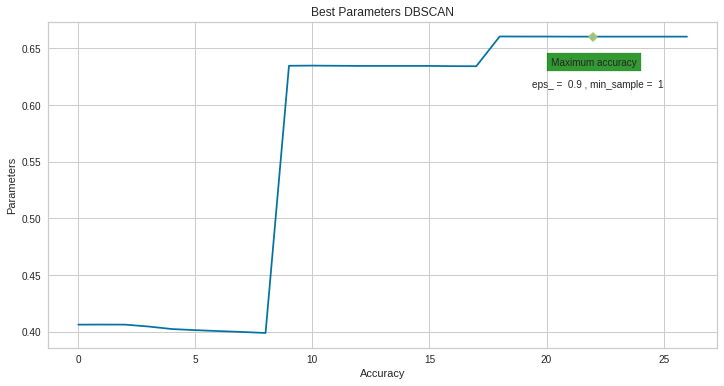

In [88]:
Y_ = range(0,27)

plt.figure(figsize=(12,6))
plt.plot(Y_, X_)
plt.plot(22, 0.6602830974188176, 'gD')

plt.text(20.2, 0.635, 'Maximum accuracy', bbox=dict(color='green', alpha=0.8))
plt.text(19.4, 0.615, 'eps_ =  0.9 , min_sample =  1', fontsize = 10)

plt.xlabel('Accuracy')
plt.ylabel('Parameters')
plt.title('Best Parameters DBSCAN')

plt.show()